In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [4]:
from train_flow_sb import unflatten, object_from_config

In [5]:
api = wandb.Api()

In [6]:
run = api.run('druhe/gw-src/12kl8jsy')

In [7]:
config = unflatten(run.config)

In [8]:
dataset = object_from_config(config, key='dataset')(**config['dataset'])

In [9]:
sb_weight = config['model']['sb_weight']

In [10]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [11]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [12]:
tempdir = tempfile.TemporaryDirectory()

In [13]:
ckpt = checkpoints[0]

In [14]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [15]:
model = HierarchicalNormalizingFlowSB.load_from_checkpoint(ckpt_path.name, dataset=dataset, sb_weight=sb_weight, flows=flows)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmprlhllb7t
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmprlhllb7t/_remote_module_non_sriptable.py


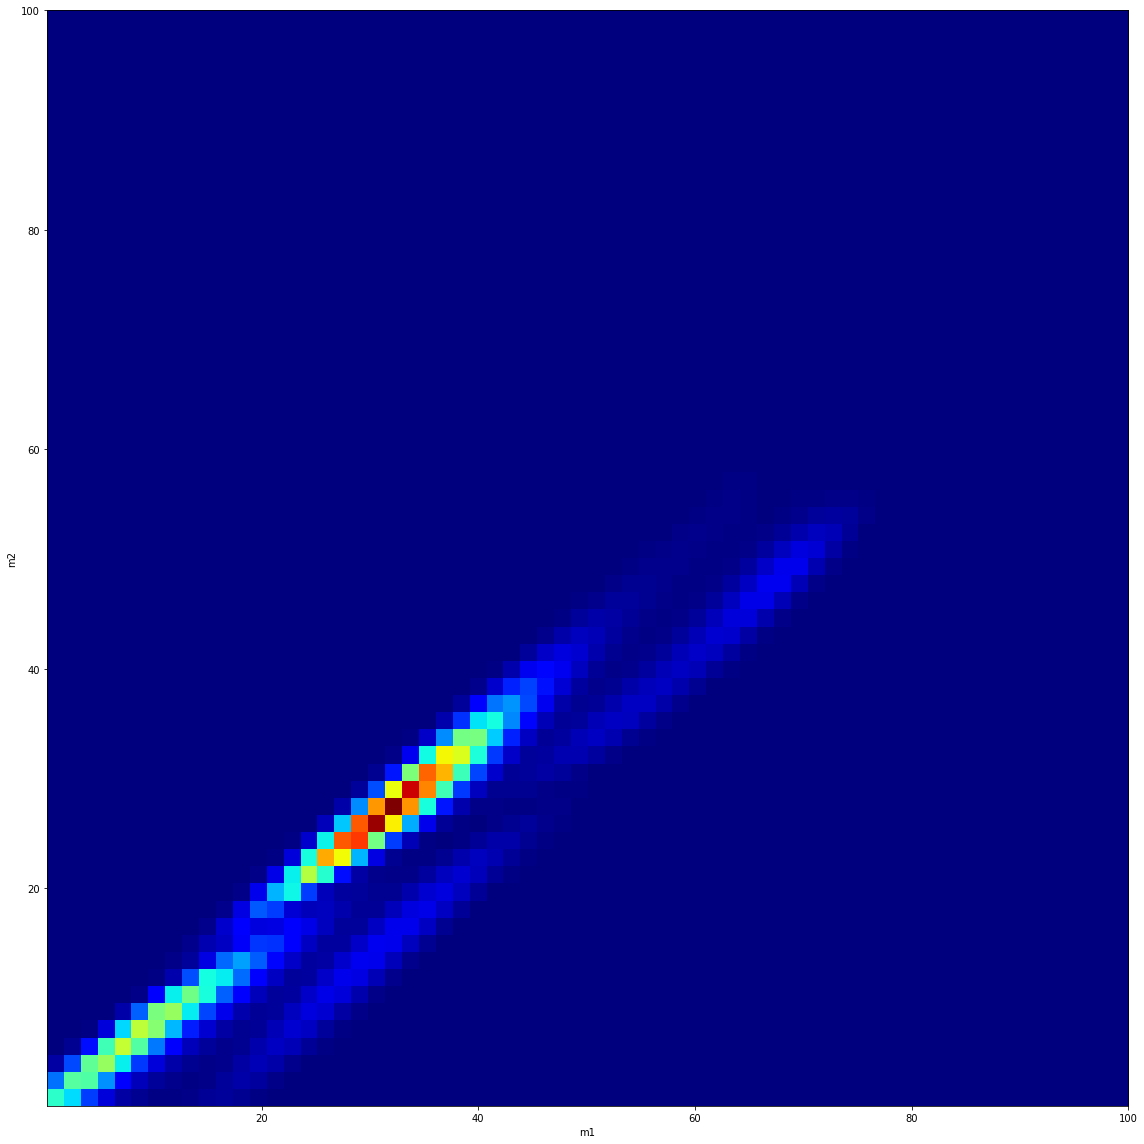

In [16]:
with torch.no_grad():
    axes_names = []
    axes = []

    for n, ax in dataset.grid.items():
        axes_names.append(n)
        axes.append(ax)

    m1, m2, z = np.stack(np.meshgrid(*axes, indexing="xy")).reshape(3, -1)

    if dataset.has_normalization:
        raise NotImplementedError
        x, y = dataset.normalize_forward(x, y)

    resolutions = [len(ax) for ax in axes]

    input = np.stack([m1, m2, z], axis=-1)
    input = torch.from_numpy(input).float()
    prob = model.log_prob(input).exp().view(*resolutions)

    pm1m2 = prob.sum(-1)

    fig = plt.figure(figsize=(16, 16), facecolor="white")
    plt.imshow(
        pm1m2,
        cmap="jet",
        origin="lower",
        extent=(
            axes[0][0],
            axes[0][-1],
            axes[1][0],
            axes[1][-1],
        ),  # origin='lower' changes the order
        aspect="auto",
    )

    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()



In [17]:
probs = [model.log_prob(input).exp().view(*resolutions) for _ in range(128)]


In [19]:
probs = torch.stack(probs)

In [21]:
m1 = probs.sum(dim=(2, 3))

In [23]:
m1_mu = m1.mean(0)
m1_std = m1.std(0)

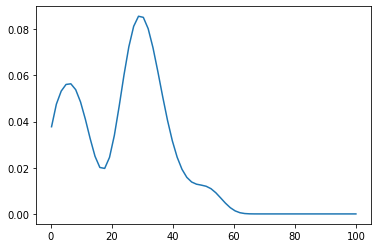

In [37]:
with torch.no_grad():
    plt.xlabel(axes_names[0])  # origin='lower' changes the order
    plt.ylabel(axes_names[1])
    plt.tight_layout()
    plt.close()
    plt.plot(axes[0], m1_mu)
#     plt.fill_between(axes[0], m1_mu - m1_std, m1_mu + m1_std, alpha=0.1)
    plt.show()



In [27]:
m1_std

tensor([ 1.5290e-02,  1.4940e-02,  1.4798e-02,  1.5036e-02,  1.5505e-02,
         1.5897e-02,  1.5873e-02,  1.5102e-02,  1.3341e-02,  1.0723e-02,
         8.6556e-03,  9.8206e-03,  1.3548e-02,  1.7149e-02,  1.9110e-02,
         1.8855e-02,  1.6694e-02,  1.4093e-02,  1.3440e-02,  1.5504e-02,
         1.8319e-02,  2.0108e-02,  2.0230e-02,  1.8796e-02,  1.6285e-02,
         1.3268e-02,  1.0230e-02,  7.4957e-03,  5.2749e-03,  3.7533e-03,
         3.0406e-03,  2.8837e-03,  2.9269e-03,  3.1654e-03,  3.5364e-03,
         3.6438e-03,  3.2305e-03,  2.4078e-03,  1.4799e-03,  7.3245e-04,
         2.8655e-04,  8.5974e-05,  1.8310e-05,  2.4887e-06,  1.9613e-07,
         8.3040e-09,  1.7881e-10,  1.9084e-12,  1.0075e-14,  2.5886e-17,
         3.0372e-20,  1.4918e-23,  2.7821e-27,  1.8511e-31,  4.1700e-36,
         2.9183e-41,  6.1883e-47,  3.9136e-53,  6.6397e-60,  2.8327e-67,
         3.1572e-75,  8.9748e-84,  5.6742e-93, 7.3297e-103],
       dtype=torch.float64, grad_fn=<StdBackward0>)